## Сделайте генератор лиц аниме на основе датасета https://www.kaggle.com/soumikrakshit/anime-faces

In [1]:
import torch
from torch import nn
import torchvision as tv
from torchvision import datasets,transforms
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nickolasblack","key":"448e372a4ba814ac39d40153fce4b0aa"}'}

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d soumikrakshit/anime-faces

 97% 428M/441M [00:01<00:00, 244MB/s]
100% 441M/441M [00:01<00:00, 232MB/s]


In [7]:
! unzip anime-faces.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/data/5499.png      
  inflating: data/data/55.png        
  inflating: data/data/550.png       
  inflating: data/data/5500.png      
  inflating: data/data/5501.png      
  inflating: data/data/5502.png      
  inflating: data/data/5503.png      
  inflating: data/data/5504.png      
  inflating: data/data/5505.png      
  inflating: data/data/5506.png      
  inflating: data/data/5507.png      
  inflating: data/data/5508.png      
  inflating: data/data/5509.png      
  inflating: data/data/551.png       
  inflating: data/data/5510.png      
  inflating: data/data/5511.png      
  inflating: data/data/5512.png      
  inflating: data/data/5513.png      
  inflating: data/data/5514.png      
  inflating: data/data/5515.png      
  inflating: data/data/5516.png      
  inflating: data/data/5517.png      
  inflating: data/data/5518.png      
  inflating: data/data/5519.png      
  inflating: data/da

In [8]:
BATCH_SIZE = 128
trainTransform  = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                    transforms.ToTensor()])
train_dataset = datasets.ImageFolder('data',transform = trainTransform)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)

In [9]:
len(train_dataset)

21551

In [10]:
train_dataset[123][0].shape

torch.Size([1, 64, 64])

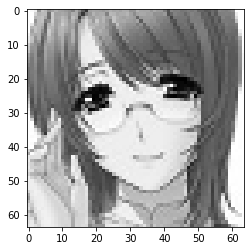

In [13]:
plt.imshow(train_dataset[85][0].squeeze(),cmap = 'gray')

In [14]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = torch.nn.functional.leaky_relu(self.fc1(x), 0.2)
        x = torch.nn.functional.leaky_relu(self.fc2(x), 0.2)
        x = torch.nn.functional.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.fc1(x), 0.2)
        x = torch.nn.functional.dropout(x, 0.3)
        x = torch.nn.functional.leaky_relu(self.fc2(x), 0.2)
        x = torch.nn.functional.dropout(x, 0.3)
        x = torch.nn.functional.leaky_relu(self.fc3(x), 0.2)
        x = torch.nn.functional.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [15]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   

In [16]:
z_dim = 200
anime_dim = 4096

G = Generator(g_input_dim = z_dim, g_output_dim = anime_dim).to(dev)
D = Discriminator(anime_dim).to(dev)

In [17]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0001
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

In [18]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, anime_dim), torch.ones(BATCH_SIZE, 1)
    x_real, y_real = torch.autograd.Variable(x_real.to(dev)), torch.autograd.Variable(y_real.to(dev))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = torch.autograd.Variable(torch.randn(BATCH_SIZE, z_dim).to(dev))
    x_fake, y_fake = G(z), torch.autograd.Variable(torch.zeros(BATCH_SIZE, 1).to(dev))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [19]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = torch.autograd.Variable(torch.randn(BATCH_SIZE, z_dim).to(dev))
    y = torch.autograd.Variable(torch.ones(BATCH_SIZE, 1).to(dev))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [20]:
n_epoch = 100
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_iter):
        if len(x) != BATCH_SIZE:
          continue
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/100]: loss_d: 0.733, loss_g: 1.195
[2/100]: loss_d: 0.730, loss_g: 1.350
[3/100]: loss_d: 0.897, loss_g: 2.671
[4/100]: loss_d: 0.770, loss_g: 4.313
[5/100]: loss_d: 0.652, loss_g: 5.999
[6/100]: loss_d: 0.242, loss_g: 6.314
[7/100]: loss_d: 0.822, loss_g: 3.802
[8/100]: loss_d: 0.826, loss_g: 3.500
[9/100]: loss_d: 0.768, loss_g: 2.360
[10/100]: loss_d: 0.899, loss_g: 2.365
[11/100]: loss_d: 0.855, loss_g: 2.709
[12/100]: loss_d: 0.850, loss_g: 2.852
[13/100]: loss_d: 0.914, loss_g: 2.702
[14/100]: loss_d: 0.865, loss_g: 2.605
[15/100]: loss_d: 0.831, loss_g: 2.810
[16/100]: loss_d: 1.353, loss_g: 1.310
[17/100]: loss_d: 1.207, loss_g: 1.143
[18/100]: loss_d: 1.377, loss_g: 0.819
[19/100]: loss_d: 1.259, loss_g: 0.920
[20/100]: loss_d: 1.136, loss_g: 1.447
[21/100]: loss_d: 0.823, loss_g: 2.770
[22/100]: loss_d: 1.176, loss_g: 1.753
[23/100]: loss_d: 0.847, loss_g: 2.393
[24/100]: loss_d: 0.940, loss_g: 2.559
[25/100]: loss_d: 1.076, loss_g: 1.588
[26/100]: loss_d: 1.185, loss_g: 1

In [21]:
test_z = torch.autograd.Variable(torch.randn(15, z_dim).to(dev))
generated = G(test_z)

In [22]:
generated.shape

torch.Size([15, 4096])

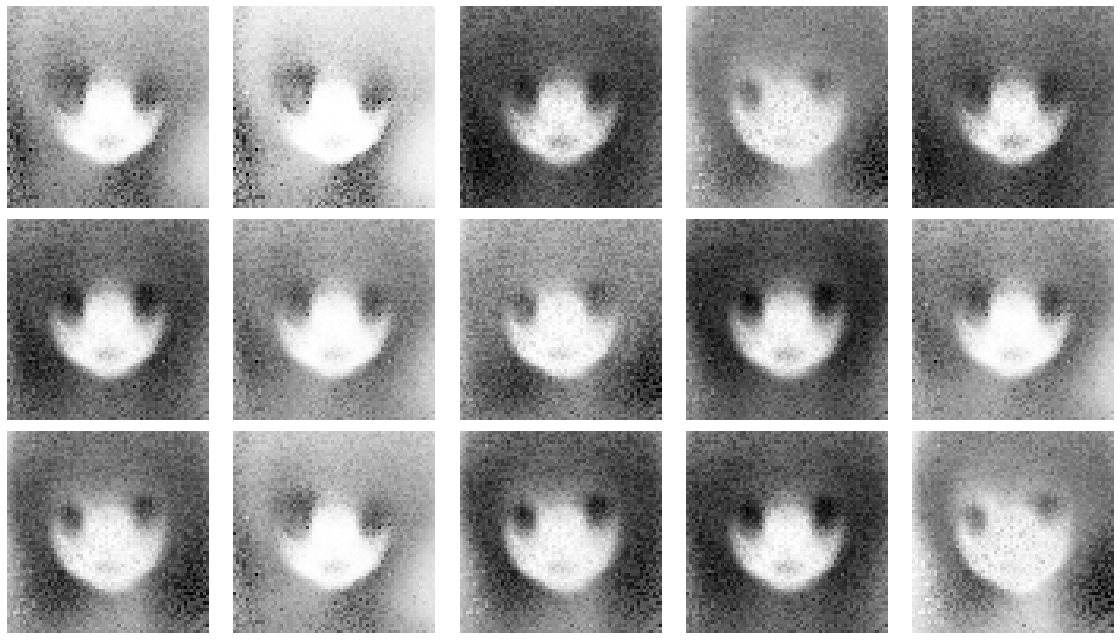

In [23]:
plt.figure(figsize=(16,9))
for x in range(5):
  for y in range(3):
    plt.subplot(3, 5, y * 5 + x + 1)
    plt.axis('off')
    plt.imshow(generated[y * 5 + x].view(64,64).cpu().detach(),cmap='gray')
plt.tight_layout()
plt.show()